## COVID-19 death analysis using XGBoost
## Author: Jun Kim
## Objective: Build a model that predicts whether a COVID-19 case results in a death or not
#### This data was obtained from the CDC and can be downloaded here: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/n8mc-b4w4.  Descriptions of the features are also listed on the site.

In [165]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pylab as plt
import shap

#### Due to the very large size of the original dataset, a sample of around 268,000 rows was used for this analysis.  The dates range from Jan 2020 to Sept 2021

#### The training set contains data from Jan 2020 to June 2021, and the test set contains data from July 2021 onwards. This results in roughly an 80%-20% split

In [166]:
# Load data
df_train = pd.read_csv('train.csv', low_memory=False)
df_test = pd.read_csv('test.csv', low_memory=False)

# Check shapes
print(df_train.shape)
print(df_test.shape)

(217667, 19)
(50303, 19)


## Data Wrangling and preparation
#### This data has a lot of missing values, but since XGBoost is known to be able to handle sparse data well, I've decided to leave in the missing values.
#### However, the One-Hot Encoder will not accept NaNs, so below is the process to remedy this:
#### 1) Create a column called "Missing" for all missing categorical values
#### 2) Encode using the One-Hot Encoder
#### 3) Wherever the "Missing" column = 1, set the entire row to Nan
#### 4) Delete the "Missing" column

In [167]:
# Drop variables
# - state_fips_code is already reflected in the state
# - There are 1,380 distinct county_fips_code values and 955 distinct res_county values in the training set
#   This would blow up the feature input space way too much
df_train.drop(['state_fips_code', 'res_county', 'county_fips_code'], axis=1, inplace=True)
df_test.drop(['state_fips_code', 'res_county', 'county_fips_code'], axis=1, inplace=True)

# Temporarily fill missing categorical for training set
df_train.replace({'res_state':{np.nan:'Missing'}}, inplace=True)
df_train.replace({'age_group':{np.nan:'Missing'}}, inplace=True)
df_train.replace({'sex':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'race':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'ethnicity':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'process':{np.nan:'Missing', 'Unknown':'Missing', \
                             'Other detection method (specify)':'Missing', 'Other':'Missing'}}, inplace=True)

# Temporarily fill missing values for test set
df_test.replace({'res_state':{np.nan:'Missing'}}, inplace=True)
df_test.replace({'age_group':{np.nan:'Missing'}}, inplace=True)
df_test.replace({'sex':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'race':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'ethnicity':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'process':{np.nan:'Missing', 'Unknown':'Missing', \
                            'Other detection method (specify)':'Missing', 'Other':'Missing'}}, inplace=True)
df_test.replace({'symptomatic_yn':{'nul':np.nan}}, inplace=True)
df_test['symptomatic_yn'] = pd.to_numeric(df_test['symptomatic_yn'])
df_test.replace({'icu_yn':{'nul':np.nan}}, inplace=True)
df_test['icu_yn'] = pd.to_numeric(df_test['icu_yn'])

# Check shapes
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (217667, 16)
Test shape: (50303, 16)


In [168]:
# One-hot encode categorical variables
# Wherever the "Missing" column is a 1, change that entire row to NaN. Then, delete the "Missing" column
# Also keep track of the new column names
columns = []

def encode_with_nan(train, test, feature, all_columns):
    '''Encodes the feature given but preserves NaNs'''
    # Encode using One-Hot encoder
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(train[[feature]])
    enc_train = encoder.transform(train[[feature]])
    enc_test = encoder.transform(test[[feature]])

    # If the "Missing" column = 1, change that entire row to NaN
    names = np.array(encoder.categories_).flatten()
    missing_index = np.argwhere(names=='Missing').flatten()
    for i in range(len(enc_train)):
        if enc_train[i, missing_index] == 1:
            enc_train[i] = np.nan
    for i in range(len(enc_test)):
        if enc_test[i, missing_index] == 1:
            enc_test[i] = np.nan
            
    # Delete the "Missing" column, then append column names
    enc_train = np.delete(enc_train, missing_index, axis=1)
    enc_test = np.delete(enc_test, missing_index, axis=1)
    names = np.delete(names, missing_index)
    for i in names:
        all_columns.append(i)
    
    return enc_train, enc_test

# Encode for each of the multiclass variables
state_train, state_test = encode_with_nan(df_train, df_test, 'res_state', columns)
age_train, age_test = encode_with_nan(df_train, df_test, 'age_group', columns)
sex_train, sex_test = encode_with_nan(df_train, df_test, 'sex', columns)
race_train, race_test = encode_with_nan(df_train, df_test, 'race', columns)
ethnicity_train, ethnicity_test = encode_with_nan(df_train, df_test, 'ethnicity', columns)
process_train, process_test = encode_with_nan(df_train, df_test, 'process', columns)

In [169]:
# Represent case_month as the number of months since Jan 2020

# Since Covid-19 has mutated and we have seen many different variants, it is expected that death rates
#   may vary depending on what variant was prevalent at the time.  Keeping the month as a variable
#   can take this into account and give heavier weight to more recent examples

month_train = (pd.to_datetime(df_train['case_month']).dt.year - 2020) * 12 + \
               pd.to_datetime(df_train['case_month']).dt.month
month_train = month_train.to_frame()

month_test = (pd.to_datetime(df_test['case_month']).dt.year - 2020) * 12 + \
               pd.to_datetime(df_test['case_month']).dt.month
month_test = month_test.to_frame()

# Append feature names
columns.append('case_month')

In [170]:
# Concatenate into the final dataset in the order that the column names were added

# Training set
y = df_train['death_yn']
df_train.drop(['case_month', 'res_state', 'age_group', 'sex', 'race', \
               'ethnicity', 'process', 'death_yn'], axis=1, inplace=True)
X = np.concatenate([state_train, age_train, sex_train, race_train, ethnicity_train, \
                    process_train, month_train, df_train], axis=1)

# Test set
y_test = df_test['death_yn']
df_test.drop(['case_month', 'res_state', 'age_group', 'sex', 'race', \
              'ethnicity', 'process', 'death_yn'], axis=1, inplace=True)
X_test = np.concatenate([state_test, age_test, sex_test, race_test, ethnicity_test, \
                         process_test, month_test, df_test], axis=1)

# Append remaining feature names
for i in df_train.columns:
    columns.append(i)

# Check shapes
print("X train shape:", X.shape)
print("y train shape:", y.shape)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)
print("Length of column names:", len(columns))

X train shape: (217667, 79)
y train shape: (217667,)
X test shape: (50303, 79)
y test shape: (50303,)
Length of column names: 79


## Modeling with XGBoost

In [171]:
# Hyperparameter grid search (Warning: this step takes a while)

# Since this is a very imbalanced dataset, I have chosen to use 
#   AUC, Precision, and Recall in addition to Accuracy
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

for depth in range(1, 12, 5): 
    for n_est in range(100, 201, 50):
        xgb = XGBClassifier(max_depth=depth, n_estimators=n_est, \
                            use_label_encoder=False, eval_metric='logloss')
        xgb.fit(X_train, y_train)
        pred = xgb.predict(X_val)
        pred_proba = xgb.predict_proba(X_val)[:,1]
        
        # Compute metrics
        accuracy = accuracy_score(y_val, pred)
        precision = precision_score(y_val, pred)
        recall = recall_score(y_val, pred)
        auc = roc_auc_score(y_val, pred_proba)
        
        # Print results
        print(f"Max depth: {depth}. n_est: {n_est}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC: {auc:.4f}\n")

Max depth: 1. n_est: 100
Precision: 0.8418
Recall: 0.4409
Accuracy: 0.9816
AUC: 0.9827

Max depth: 1. n_est: 150
Precision: 0.8357
Recall: 0.4810
Accuracy: 0.9824
AUC: 0.9841

Max depth: 1. n_est: 200
Precision: 0.8323
Recall: 0.5040
Accuracy: 0.9829
AUC: 0.9846

Max depth: 6. n_est: 100
Precision: 0.8236
Recall: 0.6264
Accuracy: 0.9855
AUC: 0.9893

Max depth: 6. n_est: 150
Precision: 0.8196
Recall: 0.6360
Accuracy: 0.9856
AUC: 0.9893

Max depth: 6. n_est: 200
Precision: 0.8104
Recall: 0.6419
Accuracy: 0.9854
AUC: 0.9892

Max depth: 11. n_est: 100
Precision: 0.7989
Recall: 0.6350
Accuracy: 0.9850
AUC: 0.9883

Max depth: 11. n_est: 150
Precision: 0.7854
Recall: 0.6398
Accuracy: 0.9847
AUC: 0.9879

Max depth: 11. n_est: 200
Precision: 0.7787
Recall: 0.6376
Accuracy: 0.9844
AUC: 0.9874



#### Best maximum depth seems to be at around 6 trees, and 200 trees gives us a good balance between precision and recall.  We will go with that for our final model.

AUC: 0.9835


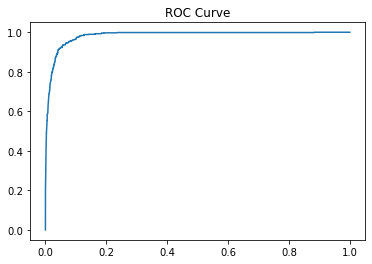

In [173]:
# Evaluate final Model with optimal hyperparameters
xgb = XGBClassifier(max_depth=6, n_estimators=200 , \
                    use_label_encoder=False, eval_metric='logloss')
xgb.fit(X, y)
pred_prob = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred_prob)
fpr, tdr, thresh = roc_curve(y_test, pred_prob)

# AUC and ROC graph
plt.plot(fpr, tdr)
plt.title("ROC Curve")
print(f'AUC: {auc:.4f}')

Top Ten Features:

65+ years. Importance: 0.33
CA. Importance: 0.16
IL. Importance: 0.04
PA. Importance: 0.03
MO. Importance: 0.03
NC. Importance: 0.03
hosp_yn. Importance: 0.02
WA. Importance: 0.02
MA. Importance: 0.02
ND. Importance: 0.02


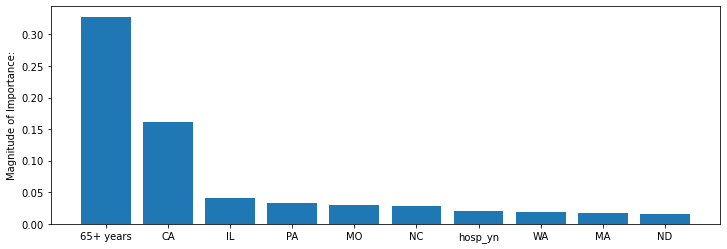

In [176]:
# Most significant variables
imp = xgb.feature_importances_.flatten()
columns = np.array(columns)
abs_imp = np.abs(imp)
indexes = np.flip(np.argsort(abs_imp))
top_ten_features = columns[indexes][:10]
top_ten_imp = abs_imp[indexes][:10]

# Plot
plt.figure(figsize=(12,4))
plt.bar(top_ten_features, top_ten_imp)
plt.ylabel("Magnitude of Importance:")

print("Top Ten Features:\n")
for i in range(len(top_ten_features)):
    print(f'{top_ten_features[i]}. Importance: {top_ten_imp[i]:.2f}')

#### As expected, being over the age of 65 is the most significant factor when it comes to predicting COVID-19 deaths.  It also appears death rates vary by state, likely because of popuation densities and varying restrictions.
#### We can take a more in-depth analysis using SHAP, which also gives us information about the direction of each feature's importance.

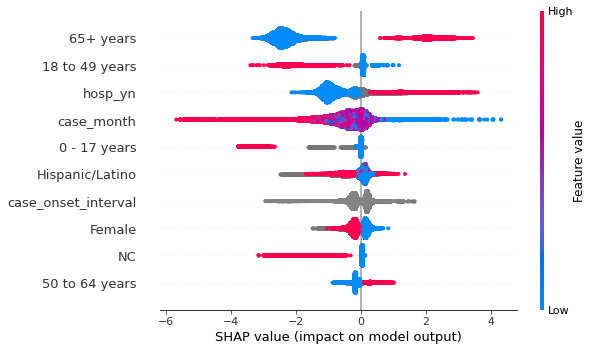

In [177]:
# Plot using SHAP
explainer = shap.TreeExplainer(xgb, feature_names=columns)
shap_values = explainer(X)
shap.summary_plot(shap_values=shap_values, features=X, max_display=10)

#### This confirms that being 65+ years old puts you at a much higher risk of dying, whereas being in a lower age bucket (18-49 years) significantly reduces that risk.
#### "Month" is also worth nothing.  As the value of "Month" increases, the lower the likelihood of death becomes.  This is good news, as it means we have made significant progress in reducing COVID-19 related deaths.  It may also indicate that more recent variants (eg. Omicron) are not as deadly.

## Thank you for checking out my model and analysis! Hope you liked it!